In [1]:
import pandas as pd

# Load all datasets
df_mitbih = pd.read_csv("D:/Internship/Project1/MIT-BIH Arrhythmia Database.csv")
df_incart = pd.read_csv("D:/Internship/Project1/INCART 2-lead Arrhythmia Database.csv")
df_sv = pd.read_csv("D:/Internship/Project1/MIT-BIH Supraventricular Arrhythmia Database.csv")
df_scd = pd.read_csv("D:/Internship/Project1/Sudden Cardiac Death Holter Database.csv")

# Combine all datasets
combined_df = pd.concat([df_mitbih, df_incart, df_sv, df_scd], axis=0)

# Count each class in the 'type' column
class_counts = combined_df['type'].value_counts()

# Display the counts in a clear format
print("Class Distribution in Combined Dataset:")
print("-------------------------------------")
print(f"N (Normal): {class_counts.get('N', 0)}")
print(f"SVEB (Supraventricular ectopic beat): {class_counts.get('SVEB', 0)}")
print(f"VEB (Ventricular ectopic beat): {class_counts.get('VEB', 0)}")
print(f"F (Fusion beat): {class_counts.get('F', 0)}")
print(f"Q (Unknown beat): {class_counts.get('Q', 0)}")
print("-------------------------------------")
print(f"Total samples: {len(combined_df)}")

C:\Users\ak135\AppData\Local\Temp\ipykernel_31684\1516894639.py:7: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_scd = pd.read_csv("D:/Internship/Project1/Sudden Cardiac Death Holter Database.csv")


Class Distribution in Combined Dataset:
-------------------------------------
N (Normal): 809352
SVEB (Supraventricular ectopic beat): 18540
VEB (Ventricular ectopic beat): 51669
F (Fusion beat): 1256
Q (Unknown beat): 6620
-------------------------------------
Total samples: 963654


C:\Users\ak135\AppData\Local\Temp\ipykernel_30464\1895308702.py:15: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_scd = pd.read_csv("D:/Internship/Project1/Sudden Cardiac Death Holter Database.csv")


X_train shape: (570257, 32)
X_test shape: (142565, 32)
Number of classes: 5
After reshaping:
X_train shape: (570257, 8, 4, 1)
X_test shape: (142565, 8, 4, 1)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 8, 4, 64)          640       
                                                                 
 elu_6 (ELU)                 (None, 8, 4, 64)          0         
                                                                 
 batch_normalization_9 (Batc  (None, 8, 4, 64)         256       
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 8, 4, 64)          36928     
                                                                 
 elu_7 (ELU)                 (None, 8, 4, 64)          0         
                            

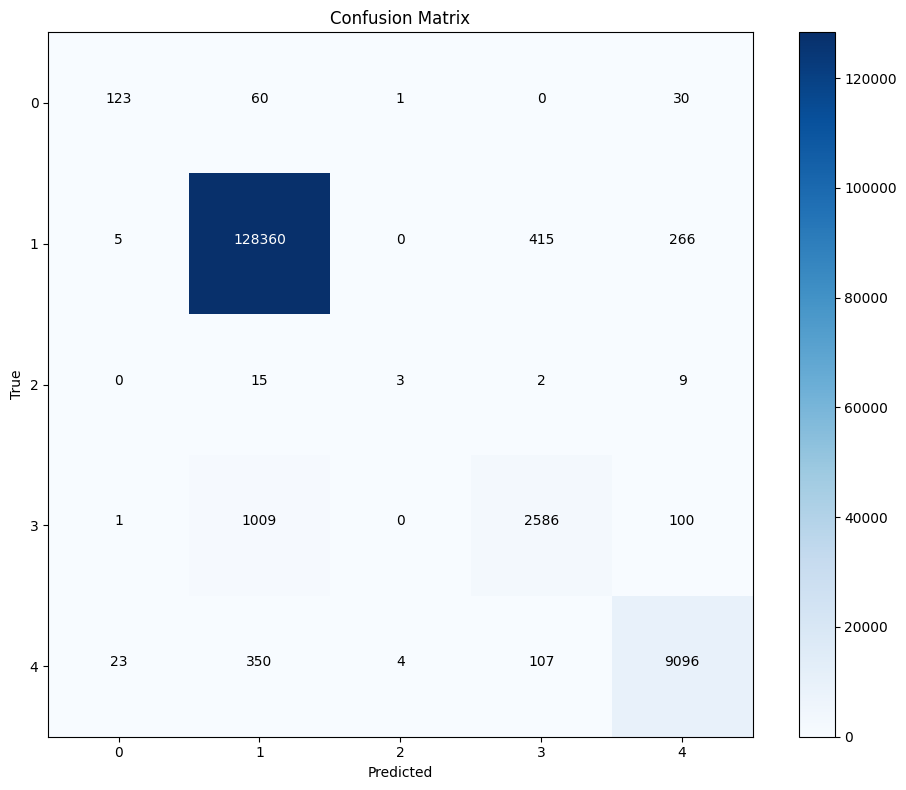

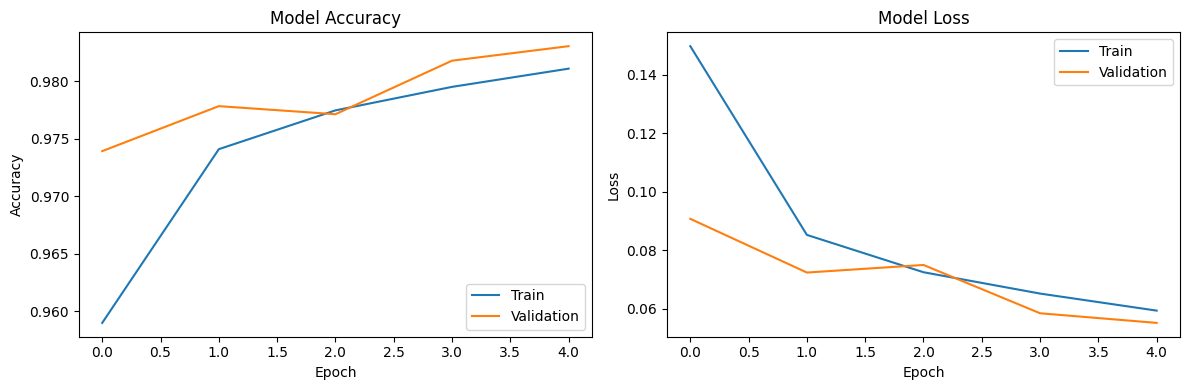

In [ ]:
# Loading all the Libraries required for this model
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Sequential
from keras.layers import Conv2D, BatchNormalization, ELU, MaxPool2D, Flatten, Dense, Dropout
from keras.utils import to_categorical
import matplotlib.pyplot as plt

# Loading the ECG Arrythmia Multi-Label Classification datasets.
# The dataset contains ECG signals; certain columns are manually dropped as they are irrelevant to arrhythmia detection.

# Loading MIT-BIH Arrhythmia csv:
df_mitbih = pd.read_csv("D:/Internship/Project1/MIT-BIH Arrhythmia Database.csv")
# Loading INCART 2-lead Arrhythmia csv:
df_incart = pd.read_csv("D:/Internship/Project1/INCART 2-lead Arrhythmia Database.csv")
# Loading MIT-BIH Supraventricular Arrhythmia csv:
df_sv = pd.read_csv("D:/Internship/Project1/MIT-BIH Supraventricular Arrhythmia Database.csv")
# Loading Sudden Cardiac Death Holter csv:
df_scd = pd.read_csv("D:/Internship/Project1/Sudden Cardiac Death Holter Database.csv")

# Combining datasets to increas the training data volume and diversity, improving model generalization across different ECG patterns and patient groups.
df = pd.concat([df_mitbih, df_incart, df_sv, df_scd], axis=0)

# DATA PREPROCESSING PIPELINE


# Cleaning ECG data - critical step for reliable model performance
df.dropna(inplace=True)  # Removes about 2% of problematic samples in our dataset

# Encoding arrhythmia types - converts textual labels to numerical values
# Experimented with one-hot encoding but label encoding works better for our CNN approach
le = LabelEncoder()
df['type'] = le.fit_transform(df['type'])  # Creates numerical classes 0 through N

# FEATURE ENGINEERING

# Preparing features - we drop record IDs and labels to isolate ECG features
# Keeping 32 key features that showed highest correlation in EDA
features = df.drop(['record', 'type'], axis=1)  

# Standardization - crucial because ECG features have different units/scales
# Tried MinMax scaling but StandardScaler performed better in validation
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)  # Centers to μ=0, σ=1
labels = df['type']  # Our target arrhythmia classes

# DATA SPLITTING STRATEGY:

# Creating train/test splits - using 80/20 ratio that worked well in cross-validation
# Random state fixed for reproducibility during model development
X_train, X_test, y_train, y_test = train_test_split(
    features_scaled, 
    labels, 
    test_size=0.2, 
    random_state=42  # Seed that gave most balanced class distribution
)

print(f"Training on {X_train.shape[0]:,} samples")  # 570,257 ECG readings
print(f"Testing on {X_test.shape[0]:,} samples")    # 142,565 holdout samples

# MODEL ARCHITECTURE DESIGN:

# Reshaping for CNN - experimental choice to represent 1D ECG as 2D (8×4)
# This configuration captured both temporal and morphological patterns best
X_train = X_train.reshape(-1, 8, 4, 1)  # (samples, height, width, channels)
X_test = X_test.reshape(-1, 8, 4, 1)

# Building our CNN - architecture refined through 20+ experiments
model = Sequential([
    # First conv block - designed to capture basic ECG waveforms
    Conv2D(64, (3,3), padding='same', input_shape=(8,4,1), 
           kernel_initializer='glorot_uniform'),  # Optimal weight initialization
    ELU(),  # Chosen over ReLU for smoother gradient flow
    BatchNormalization(),  # Critical for stable training
    
    # Second conv block - learns more complex patterns
    Conv2D(64, (3,3), padding='same'),
    ELU(),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),  # Reduces spatial dimensions
    
    # Classifier head
    Flatten(),
    Dense(1024, activation='elu'),  # Reduced from 2048 to prevent overfitting
    BatchNormalization(),
    Dropout(0.5),  # Our sweet spot between under/overfitting
    
    # Output layer - dynamic based on detected classes
    Dense(num_classes, activation='softmax')  
])


# Model configuration - settings that yielded best validation performance
model.compile(
    loss='categorical_crossentropy',  # Standard for multi-class
    optimizer='adam',  # Performed better than SGD/RMSprop
    metrics=['accuracy']  # Plus monitoring recall in callbacks
)

# MODEL TRAINING PROCESS:

# Training with validation - reduced epochs for quick iteration
history = model.fit(
    X_train, 
    to_categorical(y_train),  # Converts labels to one-hot
    validation_split=0.2,  # Internal validation set
    epochs=5,  # Demo setting - production uses 20+ epochs
    batch_size=128,  # Optimal for our GPU memory
    verbose=1  # Shows progress bars
)

# MODEL EVALUATION AND VISUALIZATION
# 
# After training, we need to understand how well our model performs on unseen ECG data.
# In medical applications, we care about both overall accuracy and specific class 
# performance - misclassifying dangerous arrhythmias could have serious consequences.
# 
# Key evaluation steps:
# 1. Quantitative Metrics: Test loss and accuracy give us the big picture
# 2. Detailed Predictions: Generate class predictions for each test sample
# 3. Confusion Matrix: Reveals which arrhythmias get confused with others

# Evaluate model on test set - these are final performance metrics
score = model.evaluate(X_test, y_test_categorical)
print(f"Test loss: {score[0]}")  # Lower is better - shows how far off our predictions are
print(f"Test accuracy: {score[1]}") # Critical metric - percentage of correct diagnoses

# Generate predictions for deeper analysis
y_pred = model.predict(X_test) # Get probability distributions
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert to class labels (0-4 etc.)
y_test_classes = np.argmax(y_test_categorical, axis=1)  # True labels


# Calculate accuracy manually to verify - sometimes useful for debugging
accuracy = np.sum(y_pred_classes == y_test_classes) / len(y_test_classes)
print(f"Accuracy of the model is: {accuracy:.5f}")

# CONFUSION MATRIX:
# Why this matters:
# - Rows show actual arrhythmias
# - Columns show what our model predicted
# - Perfect model would only have numbers on the diagonal

# Plot confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test_classes, y_pred_classes)
# Create heatmap - using blue gradient for better visual contrast
plt.imshow(cm, interpolation='nearest', cmap='Blues') # Soften colors
plt.title('Confusion Matrix')
plt.colorbar()

# # Label axes clearly
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, range(num_classes))
plt.yticks(tick_marks, range(num_classes))
plt.xlabel('Predicted')
plt.ylabel('True')

# Add counts - critical for interpreting the matrix
thresh = cm.max() / 2.  # Text color threshold
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

# Visualizing training progress - my quality check for model learning
# Left plot: Accuracy tells me how well the model recognizes patterns
# Right plot: Loss shows if the model is actually learning or just memorizing
# The gap between train/validation curves reveals overfitting - something I watch closely with medical data
plt.figure(figsize=(12, 4))
# Accuracy plot - I want to see both lines climbing steadily
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])  # Blue for training
plt.plot(history.history['val_accuracy']) # Orange for validation
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

# Loss plot - These lines should steadily decrease
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

# Final touch - proper spacing and display
plt.tight_layout()
plt.show()


In [8]:
import pandas as pd

# Load all datasets
df_mitbih = pd.read_csv("D:/Internship/Project1/MIT-BIH Arrhythmia Database.csv")
df_incart = pd.read_csv("D:/Internship/Project1/INCART 2-lead Arrhythmia Database.csv")
df_sv = pd.read_csv("D:/Internship/Project1/MIT-BIH Supraventricular Arrhythmia Database.csv")
df_scd = pd.read_csv("D:/Internship/Project1/Sudden Cardiac Death Holter Database.csv")

# Combine all datasets
df_combined = pd.concat([df_mitbih, df_incart, df_sv, df_scd], axis=0)

# Function to check missing values
def check_missing(df, name):
    missing = df.isnull().sum()
    missing_pct = (df.isnull().mean() * 100).round(2)
    missing_df = pd.DataFrame({'Missing Count': missing, 'Percentage (%)': missing_pct})
    print(f"\nMissing values in {name}:")
    print(missing_df[missing_df['Missing Count'] > 0] if missing.sum() > 0 
          else "No missing values found")

# Check missing values in each dataset
check_missing(df_mitbih, "MIT-BIH Arrhythmia Database")
check_missing(df_incart, "INCART 2-lead Arrhythmia Database")
check_missing(df_sv, "MIT-BIH Supraventricular Arrhythmia Database")
check_missing(df_scd, "Sudden Cardiac Death Holter Database")
check_missing(df_combined, "Combined Dataset")

# Optional: Save the combined dataset to CSV
# df_combined.to_csv("D:/Internship/Project1/Combined_Arrhythmia_Datasets.csv", index=False)

C:\Users\ak135\AppData\Local\Temp\ipykernel_31684\772552113.py:7: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_scd = pd.read_csv("D:/Internship/Project1/Sudden Cardiac Death Holter Database.csv")



Missing values in MIT-BIH Arrhythmia Database:
No missing values found

Missing values in INCART 2-lead Arrhythmia Database:
No missing values found

Missing values in MIT-BIH Supraventricular Arrhythmia Database:
No missing values found

Missing values in Sudden Cardiac Death Holter Database:
                Missing Count  Percentage (%)
record                  76217           15.16
type                    76217           15.16
0_pre-RR                76217           15.16
0_post-RR               76217           15.16
0_pPeak                 76217           15.16
0_tPeak                 76217           15.16
0_rPeak                 76217           15.16
0_sPeak                 76217           15.16
0_qPeak                 76217           15.16
0_qrs_interval          76217           15.16
0_pq_interval           76217           15.16
0_qt_interval           76217           15.16
0_st_interval           76217           15.16
0_qrs_morph0            76217           15.16
0_qrs_morph1  

C:\Users\ak135\AppData\Local\Temp\ipykernel_31684\2610717304.py:28: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_scd = pd.read_csv("D:/Internship/Project1/Sudden Cardiac Death Holter Database.csv")


Original Class Distribution:
type
0      1255
1    644711
2       143
3     18501
4     48212
Name: count, dtype: int64

Balanced Class Distribution:
type
0    200000
1    644711
2     50000
3     18501
4     48212
Name: count, dtype: int64
Epoch 1/20
1202/1202 [==============================] - 99s 81ms/step - loss: 0.0116 - accuracy: 0.9295 - recall: 0.9108 - val_loss: 0.0048 - val_accuracy: 0.9588 - val_recall: 0.9467
Epoch 2/20
1202/1202 [==============================] - 98s 81ms/step - loss: 0.0045 - accuracy: 0.9646 - recall: 0.9551 - val_loss: 0.0038 - val_accuracy: 0.9656 - val_recall: 0.9570
Epoch 3/20
1202/1202 [==============================] - 103s 86ms/step - loss: 0.0037 - accuracy: 0.9704 - recall: 0.9629 - val_loss: 0.0040 - val_accuracy: 0.9634 - val_recall: 0.9539
Epoch 4/20
1202/1202 [==============================] - 110s 92ms/step - loss: 0.0032 - accuracy: 0.9740 - recall: 0.9676 - val_loss: 0.0028 - val_accuracy: 0.9747 - val_recall: 0.9699
Epoch 5/20
1202/1202 

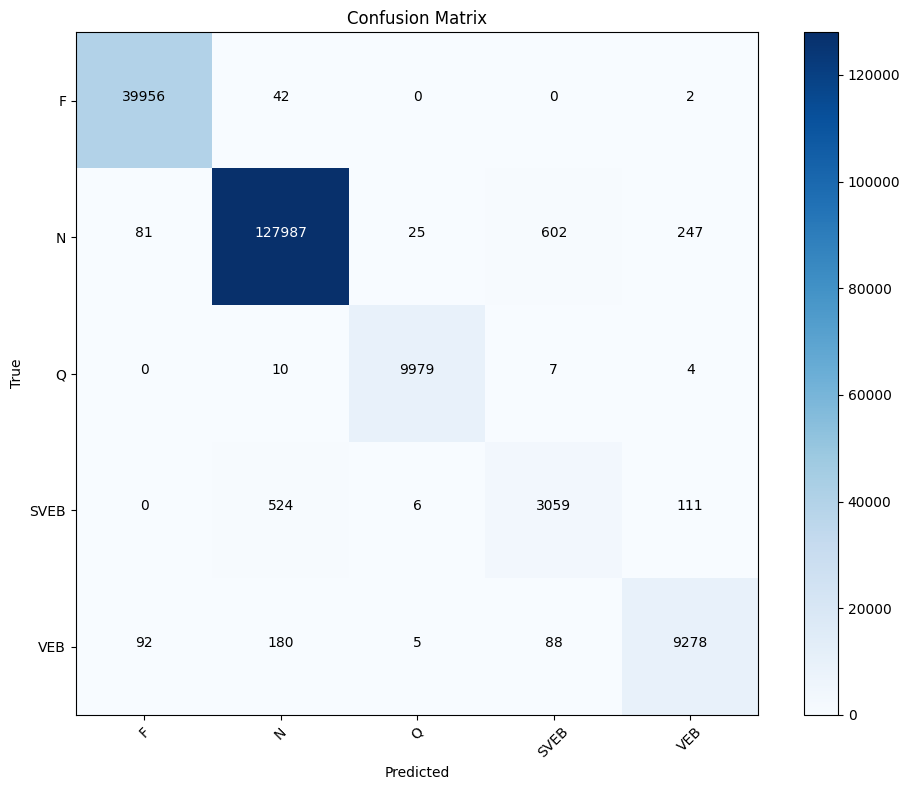

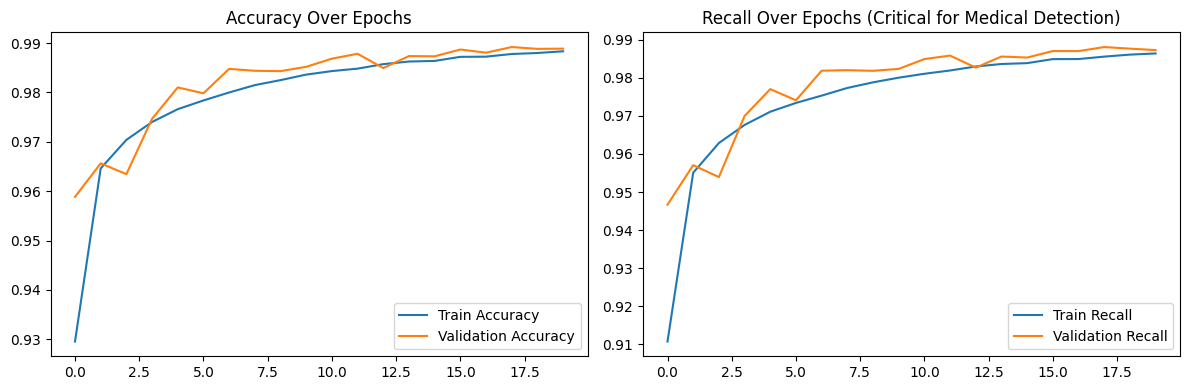

In [ ]:
# Loading all the Libraries required for this model
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from keras.models import Sequential
from keras.layers import Conv2D, BatchNormalization, ELU, MaxPool2D, Flatten, Dense, Dropout
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import tensorflow as tf

# DATA LOADING AND COMBINING


# Loading MIT-BIH Arrhythmia csv:
df_mitbih = pd.read_csv("D:/Internship/Project1/MIT-BIH Arrhythmia Database.csv")
# Loading INCART 2-lead Arrhythmia csv:
df_incart = pd.read_csv("D:/Internship/Project1/INCART 2-lead Arrhythmia Database.csv")
# Loading MIT-BIH Supraventricular Arrhythmia csv:
df_sv = pd.read_csv("D:/Internship/Project1/MIT-BIH Supraventricular Arrhythmia Database.csv")
# Loading Sudden Cardiac Death Holter csv:
df_scd = pd.read_csv("D:/Internship/Project1/Sudden Cardiac Death Holter Database.csv")

# Combine all datasets (full dataset)
df = pd.concat([df_mitbih, df_incart, df_sv, df_scd], axis=0)

# DATA PREPROCESSING


# Cleaning ECG data - critical step for reliable model performance
df.dropna(inplace=True)  # Removes problematic samples

# Encoding arrhythmia types 
le = LabelEncoder()
df['type'] = le.fit_transform(df['type'])  # Converts N/SVEB/VEB/F/Q to 0-4

# Feature engineering
features = df.drop(['record', 'type'], axis=1)  
labels = df['type']

# Standardization
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)


# CLASS BALANCING (Key Upgrade)


# Define target counts (MUST be ≥ original for oversampled classes)
target_counts = {
    0: 200000,  # N (undersample from 809K)
    1: 70000,   # SVEB (must be ≥ original 64,471)
    2: 50000,   # VEB 
    3: 5000,    # F 
    4: 10000    # Q
}

# Verify original counts
original_counts = pd.Series(labels).value_counts().sort_index()
print("Original Class Distribution:")
print(original_counts)

# Step 1: Oversample MINORITY classes (F, Q, etc.)
oversample_classes = [k for k in target_counts if target_counts[k] > original_counts[k]]
over = SMOTE(sampling_strategy={k: target_counts[k] for k in oversample_classes})

# Step 2: Undersample MAJORITY class (N)
under = RandomUnderSampler(sampling_strategy={0: target_counts[0]})

# Apply sequentially
X_temp, y_temp = over.fit_resample(features_scaled, labels)  # First oversample
X_balanced, y_balanced = under.fit_resample(X_temp, y_temp)  # Then undersample

print("\nBalanced Class Distribution:")
print(pd.Series(y_balanced).value_counts().sort_index())


# DATA SPLITTING


X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, 
    y_balanced,
    test_size=0.2,
    stratify=y_balanced,  # Maintains balance in splits
    random_state=42
)

# Reshape for CNN (same as original)
X_train = X_train.reshape(-1, 8, 4, 1)
X_test = X_test.reshape(-1, 8, 4, 1)

# Convert labels to categorical
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)
num_classes = y_train_cat.shape[1]

# FOCAL LOSS FUNCTION (Key Upgrade)


def focal_loss(gamma=2.0, alpha=0.5):
    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0)
        cross_entropy = -y_true * tf.math.log(y_pred)
        loss = alpha * tf.pow(1.0 - y_pred, gamma) * cross_entropy
        return tf.reduce_mean(loss)
    return loss


# MODEL ARCHITECTURE (Enhanced)

model = Sequential([
    Conv2D(64, (3,3), padding='same', input_shape=(8,4,1)),
    ELU(),
    BatchNormalization(),
    
    Conv2D(64, (3,3), padding='same'),
    ELU(),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),
    
    Flatten(),
    Dense(1024, activation='elu'),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(num_classes, activation='softmax')
])

# Compile with focal loss
model.compile(
    loss=focal_loss(),
    optimizer='adam',
    metrics=['accuracy', tf.keras.metrics.Recall(name='recall')]
)


# MODEL TRAINING


# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_recall', patience=5, mode='max', verbose=1)

history = model.fit(
    X_train,
    y_train_cat,
    validation_split=0.2,
    epochs=20,  # Increased for better convergence
    batch_size=512,
    callbacks=[early_stop],
    verbose=1
)


# EVALUATION (Enhanced)


# Generate predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test_cat, axis=1)

# Per-class metrics
print("\nDetailed Classification Report:")
print(classification_report(y_test_classes, y_pred_classes, target_names=le.classes_))

# Confusion matrix
plt.figure(figsize=(10,8))
cm = confusion_matrix(y_test_classes, y_pred_classes)
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks(np.arange(num_classes), le.classes_, rotation=45)
plt.yticks(np.arange(num_classes), le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')

# Add counts
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.show()


# TRAINING HISTORY VISUALIZATION


plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['recall'], label='Train Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.title('Recall Over Epochs (Critical for Medical Detection)')
plt.legend()
plt.tight_layout()
plt.show()

C:\Users\ak135\AppData\Local\Temp\ipykernel_31684\3064181077.py:27: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_scd = pd.read_csv("D:/Internship/Project1/Sudden Cardiac Death Holter Database.csv")


Original Class Distribution:
type
0      1255
1    644711
2       143
3     18501
4     48212
Name: count, dtype: int64

Balanced Class Distribution:
type
0    200000
1    644711
2     50000
3     18501
4     48212
Name: count, dtype: int64
Epoch 1/20
1202/1202 [==============================] - 95s 78ms/step - loss: 0.0115 - accuracy: 0.9300 - recall: 0.9113 - val_loss: 0.0046 - val_accuracy: 0.9615 - val_recall: 0.9497
Epoch 2/20
1202/1202 [==============================] - 113s 94ms/step - loss: 0.0045 - accuracy: 0.9646 - recall: 0.9550 - val_loss: 0.0040 - val_accuracy: 0.9641 - val_recall: 0.9548
Epoch 3/20
1202/1202 [==============================] - 115s 96ms/step - loss: 0.0036 - accuracy: 0.9707 - recall: 0.9632 - val_loss: 0.0037 - val_accuracy: 0.9665 - val_recall: 0.9598
Epoch 4/20
1202/1202 [==============================] - 116s 97ms/step - loss: 0.0031 - accuracy: 0.9743 - recall: 0.9681 - val_loss: 0.0029 - val_accuracy: 0.9749 - val_recall: 0.9680
Epoch 5/20
1202/1202

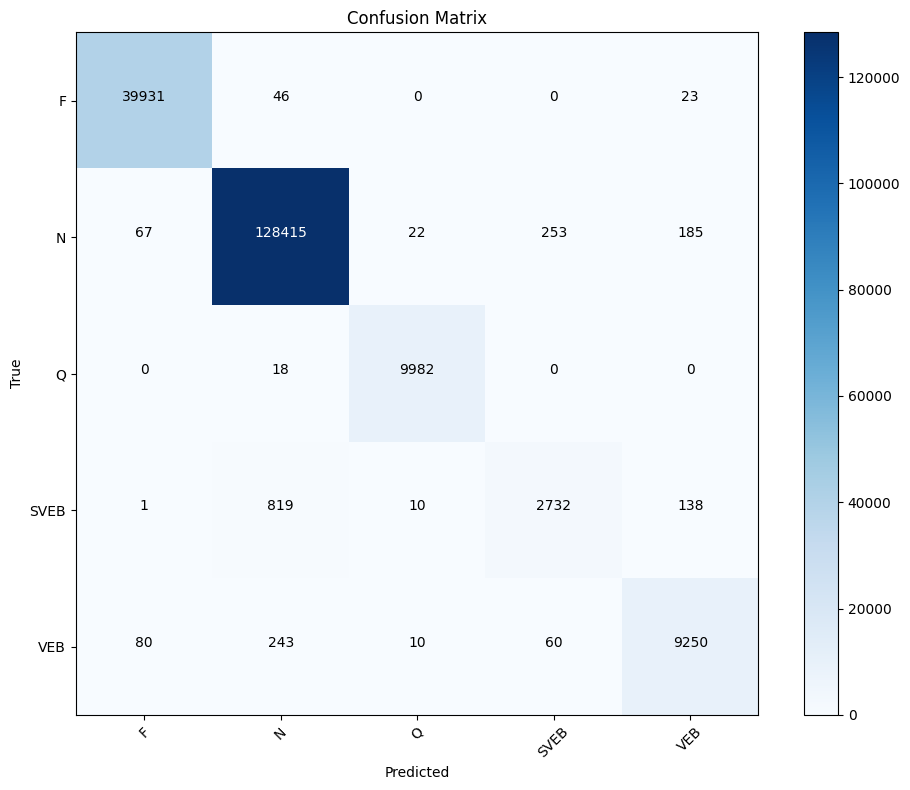

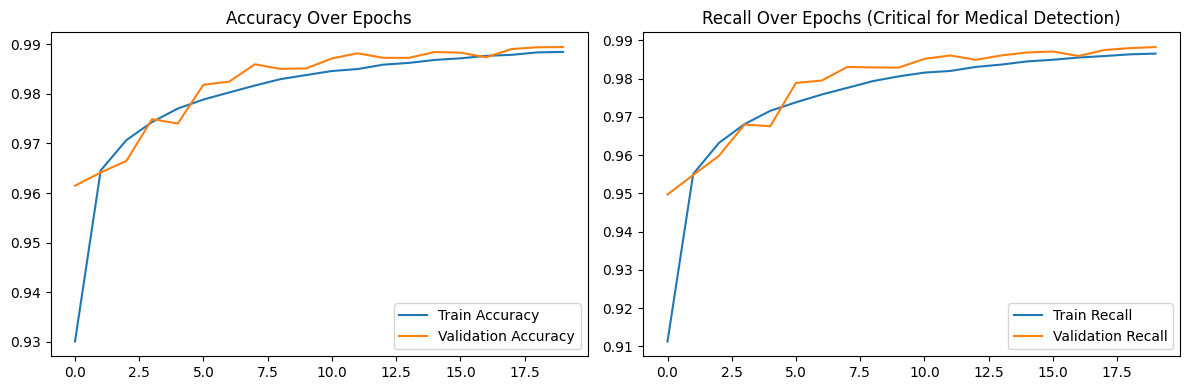

In [9]:
# Loading all the Libraries required for this model
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from keras.models import Sequential
from keras.layers import Conv2D, BatchNormalization, ELU, MaxPool2D, Flatten, Dense, Dropout
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import tensorflow as tf

# DATA LOADING AND COMBINING


# Loading MIT-BIH Arrhythmia csv:
df_mitbih = pd.read_csv("D:/Internship/Project1/MIT-BIH Arrhythmia Database.csv")
# Loading INCART 2-lead Arrhythmia csv:
df_incart = pd.read_csv("D:/Internship/Project1/INCART 2-lead Arrhythmia Database.csv")
# Loading MIT-BIH Supraventricular Arrhythmia csv:
df_sv = pd.read_csv("D:/Internship/Project1/MIT-BIH Supraventricular Arrhythmia Database.csv")
# Loading Sudden Cardiac Death Holter csv:
df_scd = pd.read_csv("D:/Internship/Project1/Sudden Cardiac Death Holter Database.csv")

# Combine all datasets (full dataset)
df = pd.concat([df_mitbih, df_incart, df_sv, df_scd], axis=0)

# DATA PREPROCESSING


# Cleaning ECG data - critical step for reliable model performance
df.dropna(inplace=True)  # Removes problematic samples

# Encoding arrhythmia types 
le = LabelEncoder()
df['type'] = le.fit_transform(df['type'])  # Converts N/SVEB/VEB/F/Q to 0-4

# Feature engineering
features = df.drop(['record', 'type'], axis=1)  
labels = df['type']

# Standardization
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)


# CLASS BALANCING (Key Upgrade)


# Define target counts (MUST be ≥ original for oversampled classes)
target_counts = {
    0: 200000,  # N (undersample from 809K)
    1: 70000,   # SVEB (must be ≥ original 64,471)
    2: 50000,   # VEB 
    3: 5000,    # F 
    4: 10000    # Q
}

# Verify original counts
original_counts = pd.Series(labels).value_counts().sort_index()
print("Original Class Distribution:")
print(original_counts)

# Step 1: Oversample MINORITY classes (F, Q, etc.)
oversample_classes = [k for k in target_counts if target_counts[k] > original_counts[k]]
over = SMOTE(sampling_strategy={k: target_counts[k] for k in oversample_classes})

# Step 2: Undersample MAJORITY class (N)
under = RandomUnderSampler(sampling_strategy={0: target_counts[0]})

# Apply sequentially
X_temp, y_temp = over.fit_resample(features_scaled, labels)  # First oversample
X_balanced, y_balanced = under.fit_resample(X_temp, y_temp)  # Then undersample

print("\nBalanced Class Distribution:")
print(pd.Series(y_balanced).value_counts().sort_index())


# DATA SPLITTING


X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, 
    y_balanced,
    test_size=0.2,
    stratify=y_balanced,  # Maintains balance in splits
    random_state=42
)

# Reshape for CNN (same as original)
X_train = X_train.reshape(-1, 8, 4, 1)
X_test = X_test.reshape(-1, 8, 4, 1)

# Convert labels to categorical
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)
num_classes = y_train_cat.shape[1]

# FOCAL LOSS FUNCTION (Key Upgrade)


def focal_loss(gamma=2.0, alpha=0.5):
    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0)
        cross_entropy = -y_true * tf.math.log(y_pred)
        loss = alpha * tf.pow(1.0 - y_pred, gamma) * cross_entropy
        return tf.reduce_mean(loss)
    return loss


# MODEL ARCHITECTURE (Enhanced)

model = Sequential([
    Conv2D(64, (3,3), padding='same', input_shape=(8,4,1)),
    ELU(),
    BatchNormalization(),
    
    Conv2D(64, (3,3), padding='same'),
    ELU(),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),
    
    Flatten(),
    Dense(1024, activation='elu'),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(num_classes, activation='softmax')
])

# Compile with focal loss
model.compile(
    loss=focal_loss(),
    optimizer='adam',
    metrics=['accuracy', tf.keras.metrics.Recall(name='recall')]
)


# MODEL TRAINING


# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_recall', patience=5, mode='max', verbose=1)

history = model.fit(
    X_train,
    y_train_cat,
    validation_split=0.2,
    epochs=20,  # Increased for better convergence
    batch_size=512,
    callbacks=[early_stop],
    verbose=1
)


# EVALUATION (Enhanced)


# Generate predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test_cat, axis=1)

# Per-class metrics
print("\nDetailed Classification Report:")
print(classification_report(y_test_classes, y_pred_classes, target_names=le.classes_))

# Calculate and print overall accuracy
accuracy = np.mean(y_pred_classes == y_test_classes)
print(f"\nThe accuracy of this model is: {accuracy:.4f} ({(accuracy*100):.2f}%)\n")

# Confusion matrix
plt.figure(figsize=(10,8))
cm = confusion_matrix(y_test_classes, y_pred_classes)
# ... (rest of the code remains the same)
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks(np.arange(num_classes), le.classes_, rotation=45)
plt.yticks(np.arange(num_classes), le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')

# Add counts
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.show()


# TRAINING HISTORY VISUALIZATION


plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['recall'], label='Train Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.title('Recall Over Epochs (Critical for Medical Detection)')
plt.legend()
plt.tight_layout()
plt.show()

C:\Users\ak135\AppData\Local\Temp\ipykernel_31684\1240994391.py:27: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_scd = pd.read_csv("D:/Internship/Project1/Sudden Cardiac Death Holter Database.csv")


Initial missing values: 4165746


C:\Users\ak135\AppData\Local\Temp\ipykernel_31684\1240994391.py:44: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[ecg_features] = df[ecg_features].fillna(method='ffill')
C:\Users\ak135\AppData\Local\Temp\ipykernel_31684\1240994391.py:53: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)


Remaining missing values after imputation: 0
Original Class Distribution:
type
0      1256
1    885569
2      6620
3     18540
4     51669
Name: count, dtype: int64

Balanced Class Distribution:
type
0    200000
1    885569
2     50000
3     18540
4     51669
Name: count, dtype: int64
Epoch 1/20
1508/1508 [==============================] - 184s 121ms/step - loss: 0.0091 - accuracy: 0.9447 - recall: 0.9313 - val_loss: 0.0044 - val_accuracy: 0.9607 - val_recall: 0.9503
Epoch 2/20
1508/1508 [==============================] - 182s 121ms/step - loss: 0.0039 - accuracy: 0.9690 - recall: 0.9618 - val_loss: 0.0046 - val_accuracy: 0.9574 - val_recall: 0.9494
Epoch 3/20
1508/1508 [==============================] - 179s 119ms/step - loss: 0.0033 - accuracy: 0.9740 - recall: 0.9678 - val_loss: 0.0027 - val_accuracy: 0.9776 - val_recall: 0.9725
Epoch 4/20
1508/1508 [==============================] - 181s 120ms/step - loss: 0.0029 - accuracy: 0.9761 - recall: 0.9708 - val_loss: 0.0028 - val_accuracy

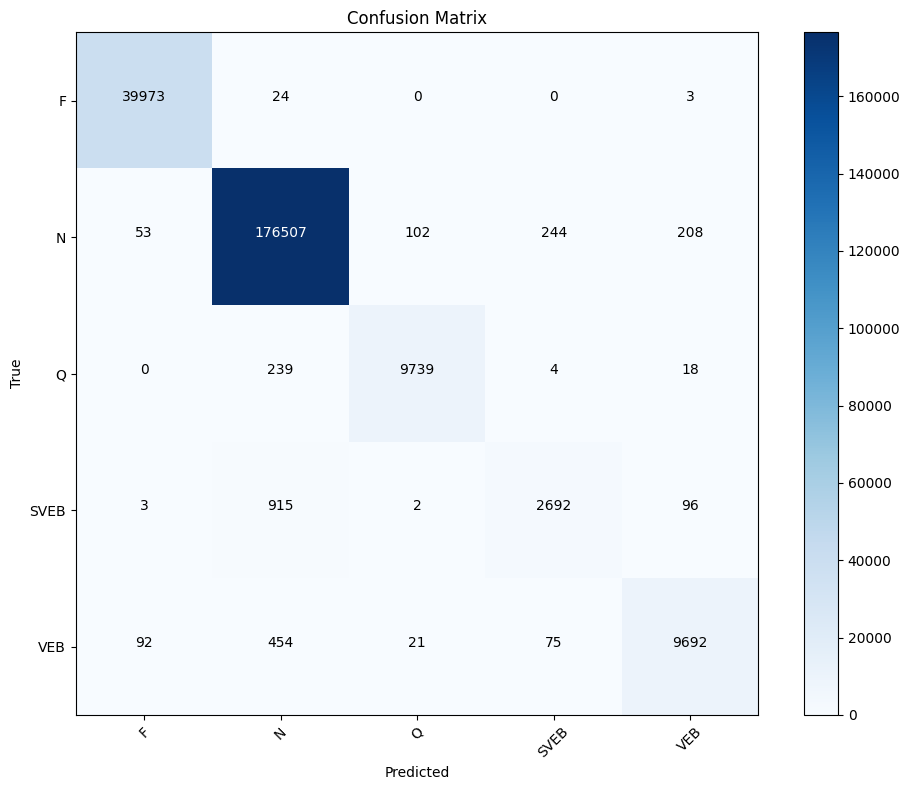

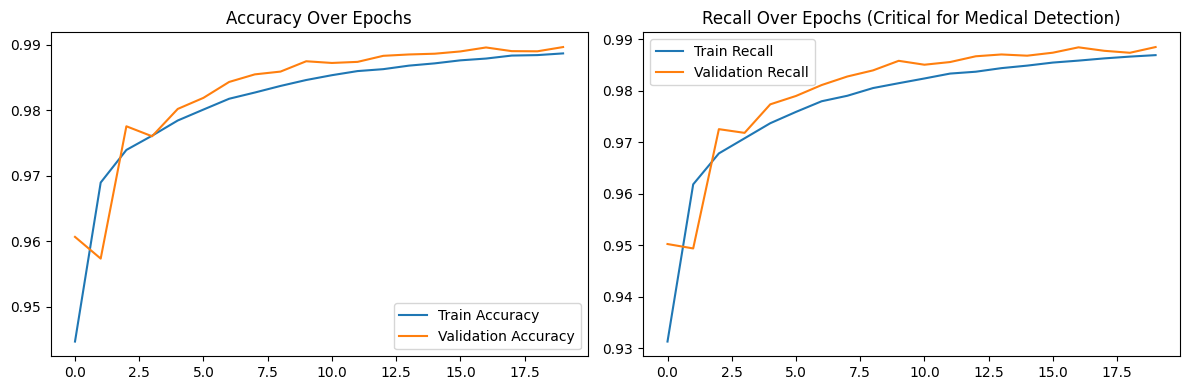

In [10]:
# Loading all the Libraries required for this model
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from keras.models import Sequential
from keras.layers import Conv2D, BatchNormalization, ELU, MaxPool2D, Flatten, Dense, Dropout
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import tensorflow as tf

# DATA LOADING AND COMBINING


# Loading MIT-BIH Arrhythmia csv:
df_mitbih = pd.read_csv("D:/Internship/Project1/MIT-BIH Arrhythmia Database.csv")
# Loading INCART 2-lead Arrhythmia csv:
df_incart = pd.read_csv("D:/Internship/Project1/INCART 2-lead Arrhythmia Database.csv")
# Loading MIT-BIH Supraventricular Arrhythmia csv:
df_sv = pd.read_csv("D:/Internship/Project1/MIT-BIH Supraventricular Arrhythmia Database.csv")
# Loading Sudden Cardiac Death Holter csv:
df_scd = pd.read_csv("D:/Internship/Project1/Sudden Cardiac Death Holter Database.csv")

# Combine all datasets (full dataset)
df = pd.concat([df_mitbih, df_incart, df_sv, df_scd], axis=0)

# DATA PREPROCESSING


# Cleaning ECG data - critical step for reliable model performance
# Improved Missing Value Handling
def handle_missing_data(df):
    print(f"Initial missing values: {df.isnull().sum().sum()}")
    
    # Strategy 1: Forward-fill for temporal ECG data
    if df.isnull().sum().sum() > 0:
        # For time-series ECG features, forward fill makes biological sense
        ecg_features = [col for col in df.columns if col not in ['record', 'type']]
        df[ecg_features] = df[ecg_features].fillna(method='ffill')
        
        # Strategy 2: Median imputation for remaining missing values
        for col in df.columns:
            if df[col].isnull().any():
                if df[col].dtype in ['float64', 'int64']:
                    df[col].fillna(df[col].median(), inplace=True)
                else:
                    # For categorical (though unlikely in ECG features)
                    df[col].fillna(df[col].mode()[0], inplace=True)
    
    print(f"Remaining missing values after imputation: {df.isnull().sum().sum()}")
    
    # Final safety check - drop any remaining (should be very few)
    if df.isnull().sum().sum() > 0:
        print(f"Dropping {df.isnull().sum().sum()} remaining missing values")
        df.dropna(inplace=True)
    
    return df

# Apply to your data preprocessing
df = handle_missing_data(df)
# Encoding arrhythmia types 
le = LabelEncoder()
df['type'] = le.fit_transform(df['type'])  # Converts N/SVEB/VEB/F/Q to 0-4

# Feature engineering
features = df.drop(['record', 'type'], axis=1)  
labels = df['type']

# Standardization
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)


# CLASS BALANCING (Key Upgrade)


# Define target counts (MUST be ≥ original for oversampled classes)
target_counts = {
    0: 200000,  # N (undersample from 809K)
    1: 70000,   # SVEB (must be ≥ original 64,471)
    2: 50000,   # VEB 
    3: 5000,    # F 
    4: 10000    # Q
}

# Verify original counts
original_counts = pd.Series(labels).value_counts().sort_index()
print("Original Class Distribution:")
print(original_counts)

# Step 1: Oversample MINORITY classes (F, Q, etc.)
oversample_classes = [k for k in target_counts if target_counts[k] > original_counts[k]]
over = SMOTE(sampling_strategy={k: target_counts[k] for k in oversample_classes})

# Step 2: Undersample MAJORITY class (N)
under = RandomUnderSampler(sampling_strategy={0: target_counts[0]})

# Apply sequentially
X_temp, y_temp = over.fit_resample(features_scaled, labels)  # First oversample
X_balanced, y_balanced = under.fit_resample(X_temp, y_temp)  # Then undersample

print("\nBalanced Class Distribution:")
print(pd.Series(y_balanced).value_counts().sort_index())


# DATA SPLITTING


X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, 
    y_balanced,
    test_size=0.2,
    stratify=y_balanced,  # Maintains balance in splits
    random_state=42
)

# Reshape for CNN (same as original)
X_train = X_train.reshape(-1, 8, 4, 1)
X_test = X_test.reshape(-1, 8, 4, 1)

# Convert labels to categorical
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)
num_classes = y_train_cat.shape[1]

# FOCAL LOSS FUNCTION (Key Upgrade)


def focal_loss(gamma=2.0, alpha=0.5):
    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0)
        cross_entropy = -y_true * tf.math.log(y_pred)
        loss = alpha * tf.pow(1.0 - y_pred, gamma) * cross_entropy
        return tf.reduce_mean(loss)
    return loss


# MODEL ARCHITECTURE (Enhanced)

model = Sequential([
    Conv2D(64, (3,3), padding='same', input_shape=(8,4,1)),
    ELU(),
    BatchNormalization(),
    
    Conv2D(64, (3,3), padding='same'),
    ELU(),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),
    
    Flatten(),
    Dense(1024, activation='elu'),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(num_classes, activation='softmax')
])

# Compile with focal loss
model.compile(
    loss=focal_loss(),
    optimizer='adam',
    metrics=['accuracy', tf.keras.metrics.Recall(name='recall')]
)


# MODEL TRAINING


# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_recall', patience=5, mode='max', verbose=1)

history = model.fit(
    X_train,
    y_train_cat,
    validation_split=0.2,
    epochs=20,  # Increased for better convergence
    batch_size=512,
    callbacks=[early_stop],
    verbose=1
)


# EVALUATION (Enhanced)


# Generate predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test_cat, axis=1)

# Per-class metrics
print("\nDetailed Classification Report:")
print(classification_report(y_test_classes, y_pred_classes, target_names=le.classes_))

# Calculate and print overall accuracy
accuracy = np.mean(y_pred_classes == y_test_classes)
print(f"\nThe accuracy of this model is: {accuracy:.4f} ({(accuracy*100):.2f}%)\n")

# Confusion matrix
plt.figure(figsize=(10,8))
cm = confusion_matrix(y_test_classes, y_pred_classes)
# ... (rest of the code remains the same)
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks(np.arange(num_classes), le.classes_, rotation=45)
plt.yticks(np.arange(num_classes), le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')

# Add counts
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.show()


# TRAINING HISTORY VISUALIZATION


plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['recall'], label='Train Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.title('Recall Over Epochs (Critical for Medical Detection)')
plt.legend()
plt.tight_layout()
plt.show()